# 0.0. IMPORTS

In [60]:
import math
import numpy as np
import pandas as pd
import inflection
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy import stats
from tabulate import tabulate
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cramer_v(x,y):
    cm= pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k**2/ (n-1))
    rcorr = r - (r**2/ (n-1))    
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))


## 0.2. Loading data


In [3]:
df_sales_raw = pd.read_csv ('C:/Users/Daniela/Google Drive/data_science_producao/data/train.csv', low_memory = False)
df_store_raw = pd.read_csv ('C:/Users/Daniela/Google Drive/data_science_producao/data/store.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
879169,220,6,2013-05-04,3802,499,1,0,0,0,a,a,1000.0,9.0,2008.0,0,NaN,NaN,NaN


# 1.0. DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimension

In [7]:
print ('Número de Rows: {}'.format(df1.shape[0]))
print ('Número de Columns: {}'.format(df1.shape[1]))

Número de Rows: 1017209
Número de Columns: 18



## 1.3. Data Type

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance  
df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                 
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)       

#promo_interval  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change type

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive statistical

In [14]:
num_attirbutes= df1.select_dtypes(include = ['int64', 'float64'])
cat_attirbutes= df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attribute

In [15]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attirbutes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attirbutes.apply(np.median)).T

#Dispersion - std, min, max. range, std, skew, kurtosis
d1 = pd.DataFrame(num_attirbutes.apply(np.std)).T
d2 = pd.DataFrame(num_attirbutes.apply(min)).T
d3 = pd.DataFrame(num_attirbutes.apply(max)).T
d4 = pd.DataFrame(num_attirbutes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attirbutes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attirbutes.apply(lambda x: x.kurtosis())).T

#Concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5,d6]).T.reset_index()
m.columns = ['Attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'Kurtosis']
m

,Attribute,min,max,range,mean,median,std,skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. categorical attributes

In [16]:
cat_attirbutes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

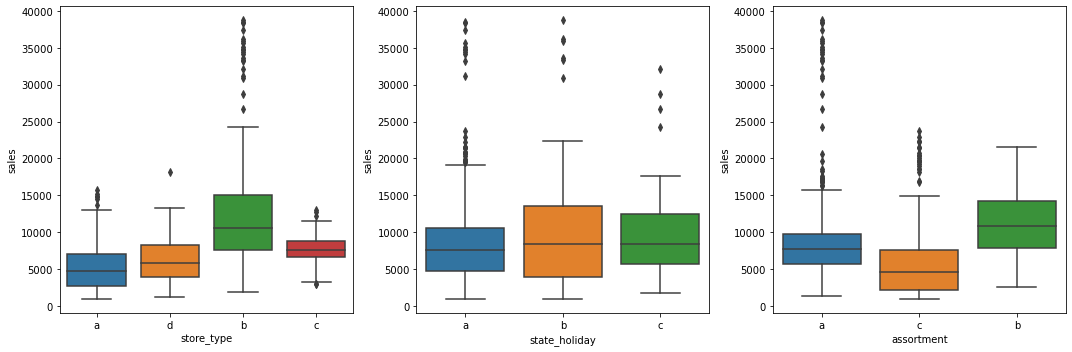

In [17]:
aux1= df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(x= 'store_type', y = 'sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot(x= 'state_holiday', y = 'sales', data= aux1)
            
plt.subplot(1,3,3)
sns.boxplot(x= 'assortment', y = 'sales', data= aux1)

fig.tight_layout()

# 2.0. FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

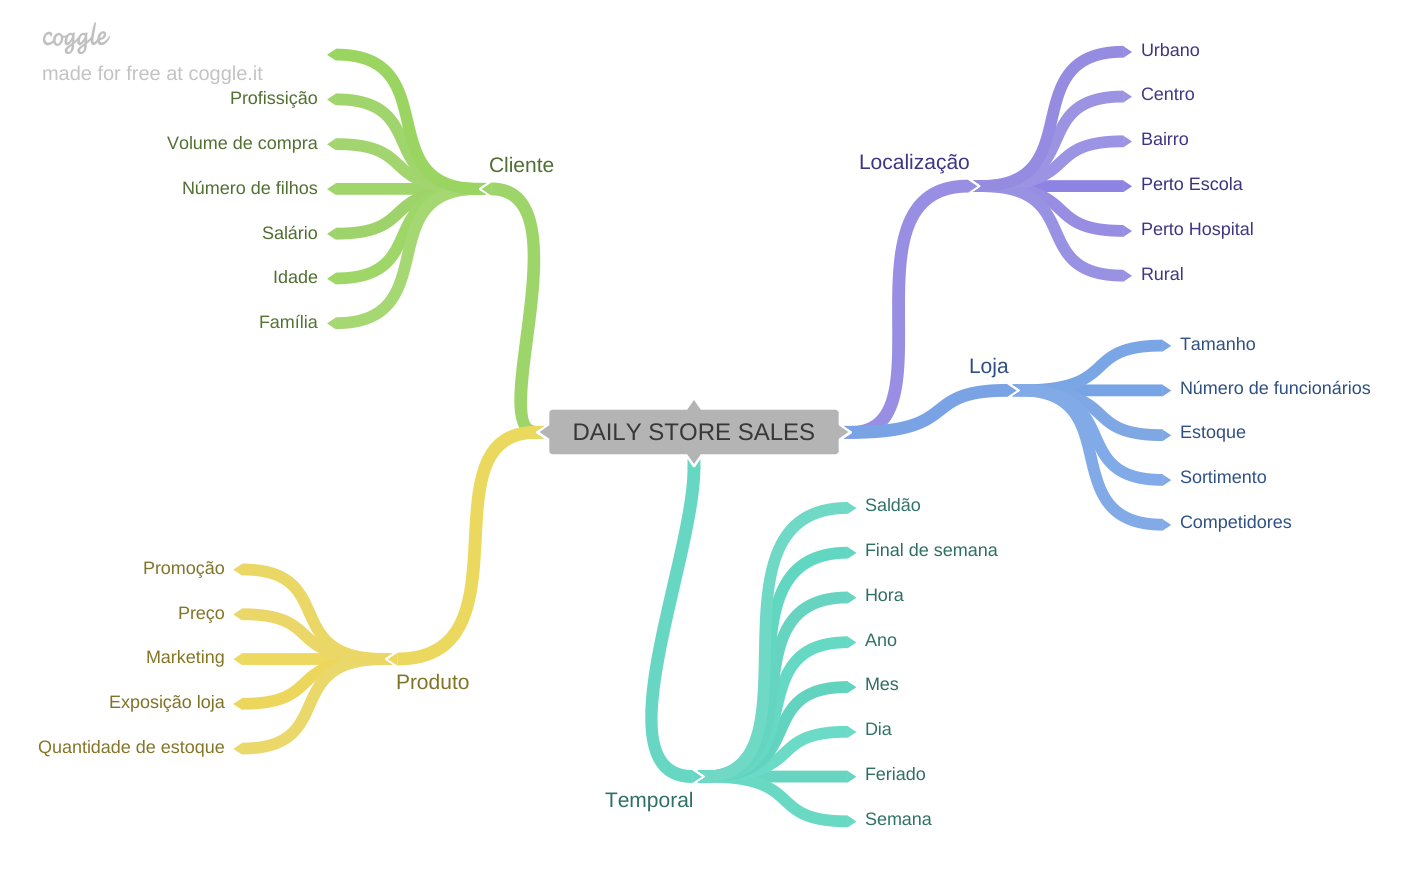

In [19]:
Image('img/MindMapHypothesis.png')

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses Lojas

**1.** Lojas com maior número de funcionárioa deveria vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (com descontos maiores), deveriam vender mais.

**5.** Lojas com promoções mais ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre de ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2.4 Lista Final de hipóteses priorizadas

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções mais ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre de ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


 ## 2.3. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear #isocalendar().week --> vai ser assim nas próximas versões

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year= x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )

<ipython-input-20-1ae638a3bf97>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear #isocalendar().week --> vai ser assim nas próximas versões


# 3.0 FILTRAGEM DE VARIÁVEL

In [21]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [22]:
df3.groupby('assortment').sum() 

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
assortment,,,,,,,,,,,,,,,,,,,,
basic,299121594,2148941,2945750070,332766938,444909,204970,96492,2.696623e+09,3686192,1080165757,267232,12988023,1081743646,83312,1082323502,3129382,8438917,12637717,25710271,30102964
extended,263717376,1885046,2856484241,294302292,391271,179944,83726,3.331087e+09,3164779,948082651,238362,10852351,948988986,73485,949462091,2769200,7403852,11187053,16397918,25203838
extra,5200774,33161,70946312,16972525,8212,3166,1503,9.876640e+06,52673,16672112,3584,185119,16698825,1105,16702739,48797,130250,197144,369087,218679


## 3.1. Filtragem das linhas

In [23]:
df3= df3[(df3['open'] != 0) & (df3['sales']> 0)]

## 3.2 FIltragem de colunas

In [24]:
clos_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(clos_drop, axis =1 )

# 4.0 ANALISE EXLORATÓRIA DOS DADOS

In [25]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1. Response Variable

C:\Users\Daniela\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

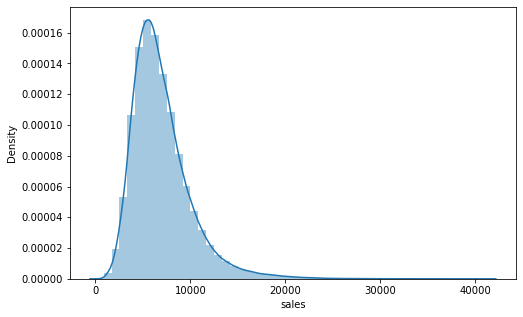

In [26]:
fig = plt.figure(figsize = (8,5))
sns.distplot(df4['sales']) 

### 4.1.2. Numerical Variable

<Figure size 432x288 with 0 Axes>

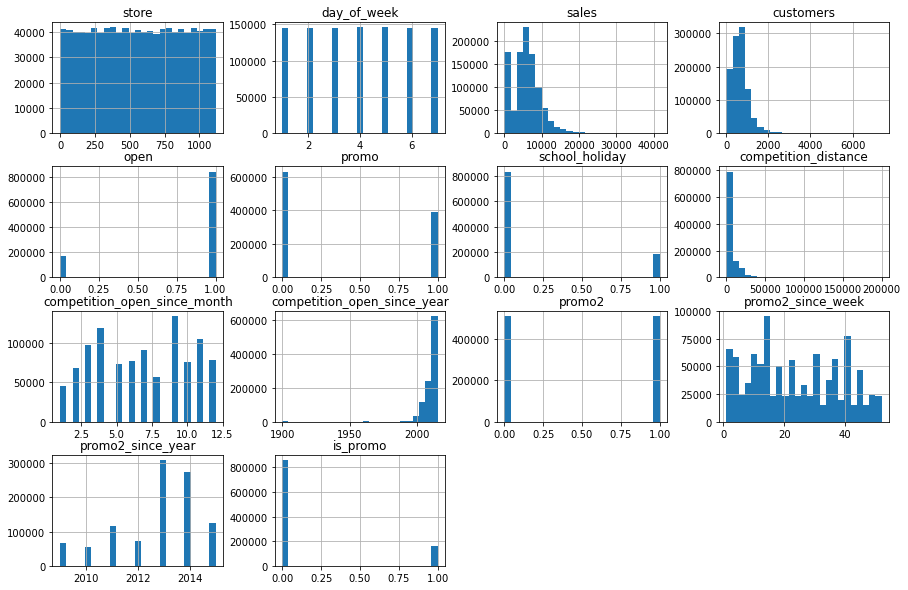

In [27]:
fig = plt.figure ()
num_attirbutes.hist(bins = 25, figsize = (15,10));


### 4.1.3 Categorical Variable

C:\Users\Daniela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Daniela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Daniela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

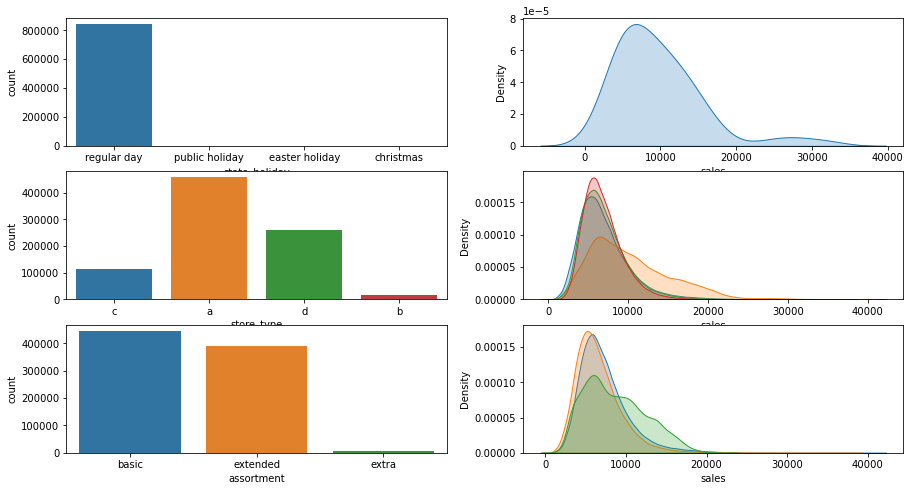

In [28]:
fig = plt.figure (figsize=(15,8))
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**Falsa** Loja com MAIOR SORTIMENTO vende MENOS

<AxesSubplot:xlabel='year_week'>

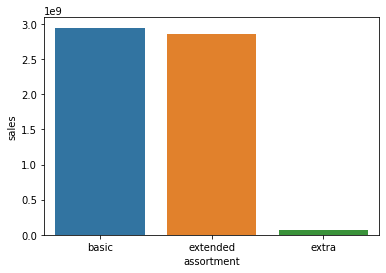

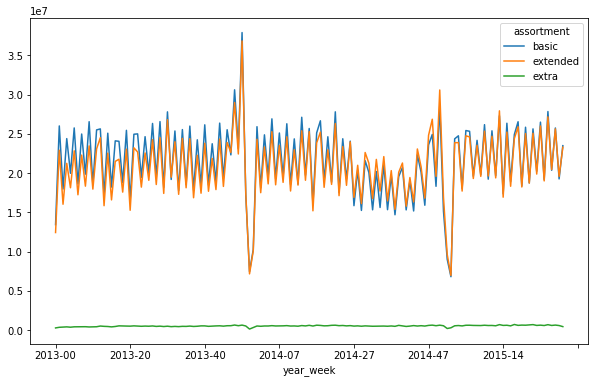

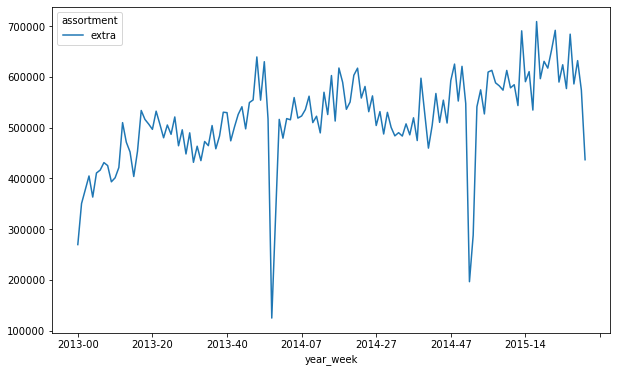

In [29]:
aux1= df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2=df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns= 'assortment', values = 'sales').plot(figsize=(10,6))

aux3=aux2[aux2['assortment'] =='extra']
aux3.pivot(index='year_week', columns= 'assortment', values = 'sales').plot(figsize=(10,6))

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Falsa** Lojas com COMPETIDORES PRÓXIMOS vendem MAIS


<AxesSubplot:>

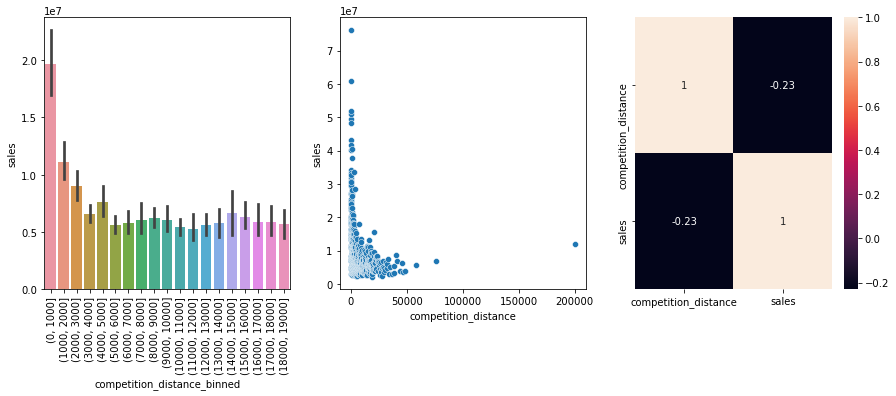

In [30]:
aux1= df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins= list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2= aux1[['competition_distance_binned', 'sales']]

fig=plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**Falsa** Lojas com COMPETIDORES PRÓXIMOS à mais tempo vendem MENOS

<AxesSubplot:>

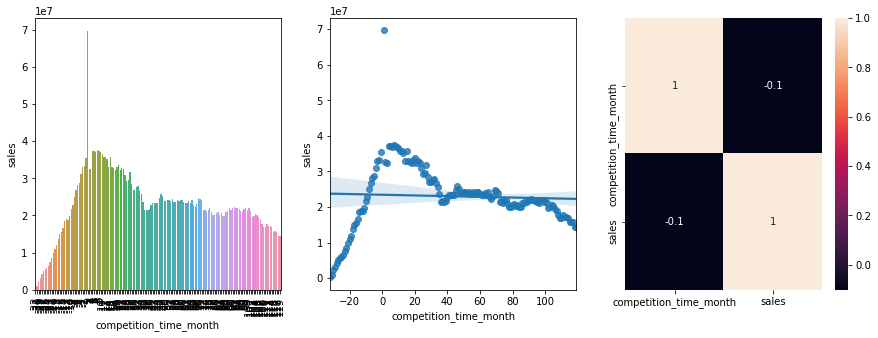

In [31]:
aux1= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2= aux1[(aux1['competition_time_month'] <120) & (aux1['competition_time_month'] != 0)]

fig=plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H4.** Lojas com promoções mais ativas por mais tempo deveriam vender mais.
**Falsa** Lojas com promoção ativa por mais tempo vendem menos depois de um certo tempo

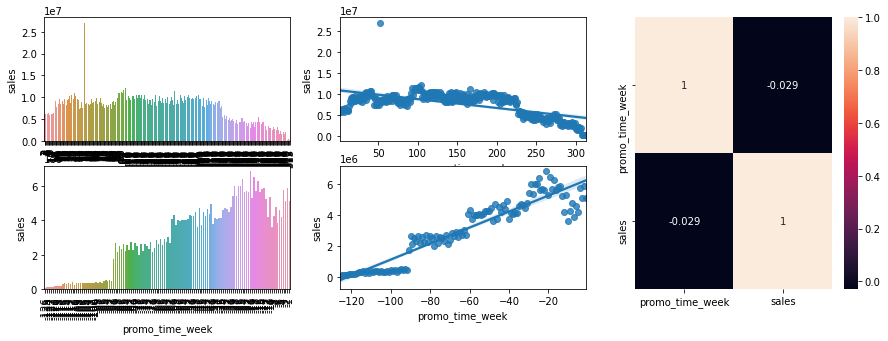

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

fig=plt.figure(figsize=(15,5))

grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendido
sns.barplot(x='promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x='promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **5.** <s>Lojas com mais dias de promoção deveriam vender mais.<\s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa** Lojas com mais promoçoes consecutivas vendem menos

In [33]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


6

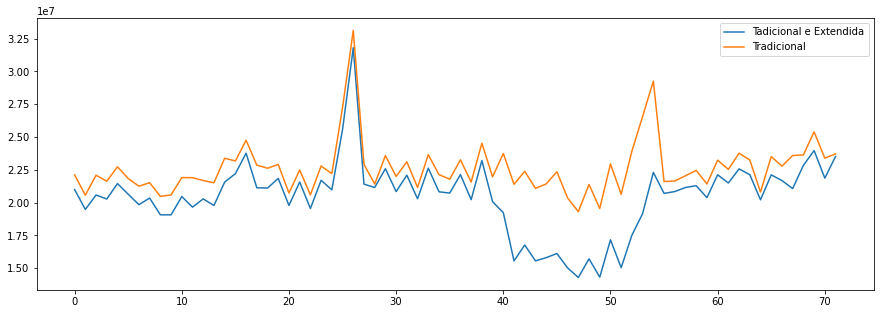

In [34]:
aux1= df4[(df4['promo'] ==1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(15,5))

aux2= df4[(df4['promo'] ==1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax, figsize=(15,5))

ax.legend(labels = ['Tadicional e Extendida', 'Tradicional']);6

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado do natal vendem menos

<AxesSubplot:xlabel='year', ylabel='sales'>

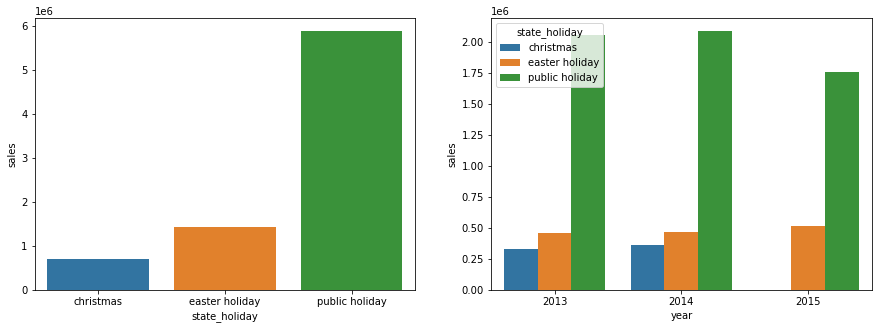

In [35]:
aux = df4[df4['state_holiday'] != 'regular day']

fig=plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y ='sales', data= aux1);

plt.subplot(1,2,2)
aux2= aux[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x= 'year', y= 'sales', hue='state_holiday', data=aux2)

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas vendem menos ao longo do ano

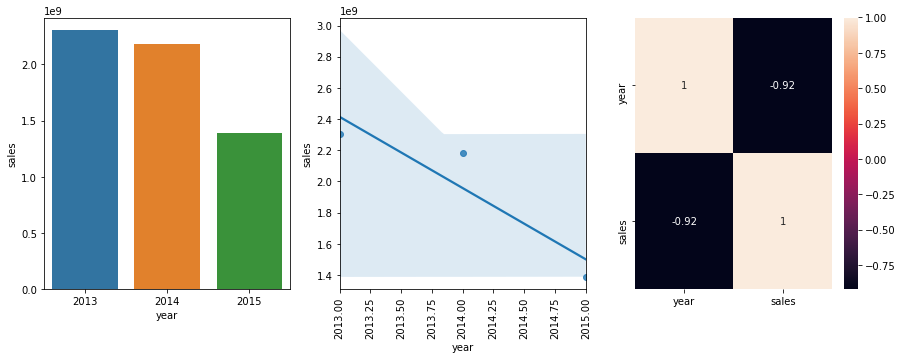

In [36]:
aux1= df4[['year', 'sales']].groupby('year').sum().reset_index()

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);
plt.xticks(rotation =90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre de ano.
**Falsa** Lojas vendem menos no segundo semestre

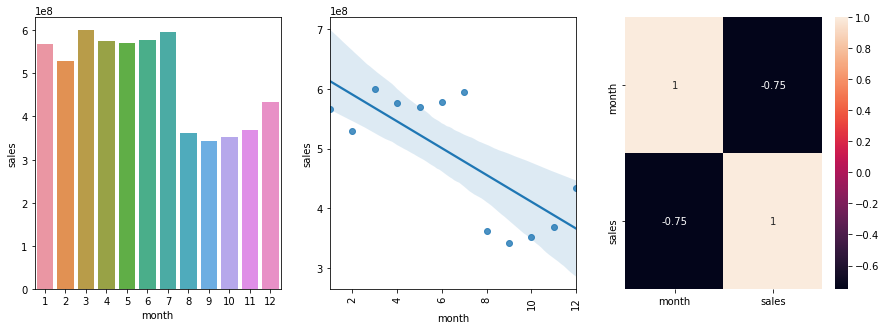

In [37]:
aux1= df4[['month', 'sales']].groupby('month').sum().reset_index()

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);
plt.xticks(rotation =90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Falsa** A mediana das vendas antes e após o dia 10 são semelhantes, logo depois do dia 10 a loja não vende mais

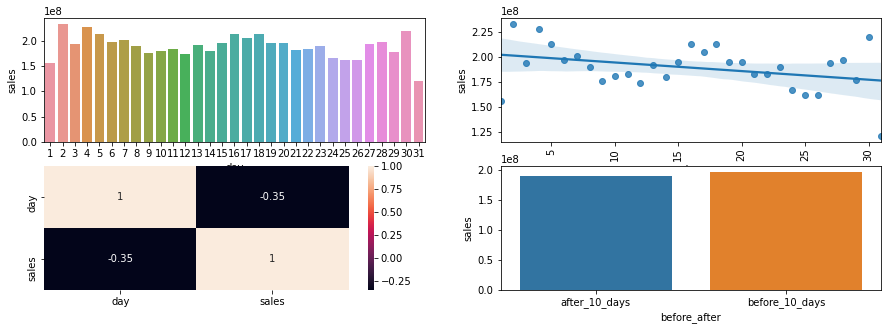

In [38]:
aux1= df4[['day', 'sales']].groupby('day').sum().reset_index()

fig = plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);
plt.xticks(rotation =90)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2=aux1[['before_after', 'sales']].groupby('before_after').median().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);


### **H11.** Lojas deveriam vender menos aos finais de semana.
**Verdadeira** Lojas vendem menos no final de semana

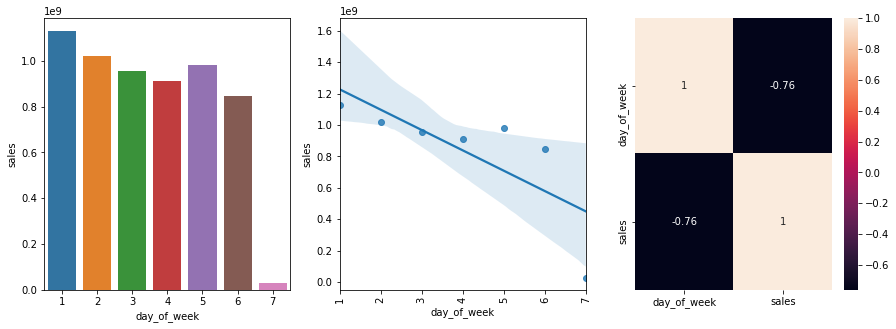

In [39]:
aux1= df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);
plt.xticks(rotation =90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos durante os feriados escolares, com excessão dos meses de julho e agosto

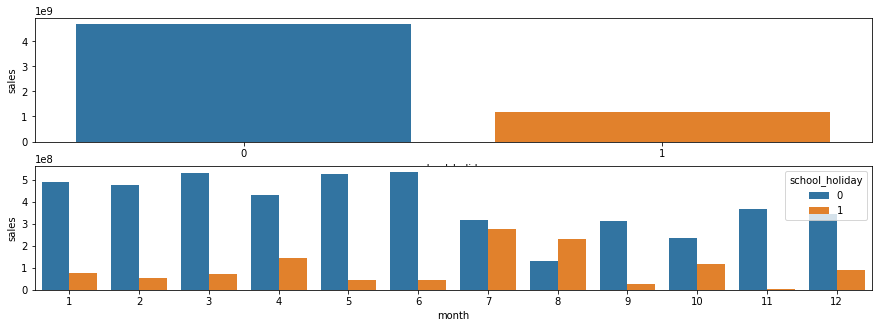

In [40]:
fig = plt.figure(figsize=(15,5))

aux1=df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data= aux1);

aux2=df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', hue='school_holiday', y='sales', data= aux2);

### 4.2.1. Resumos dos concluões da validação das hipótese

In [41]:
tab = [['Hipóstese', 'Conlusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'BAixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']
      ]
print(tabulate(tab, headers='firstrow'))

Hipóstese    Conlusão    Relevância
-----------  ----------  ------------
H1           Falsa       Baixa
H2           Falsa       Media
H3           Falsa       Média
H4           Falsa       Baixa
H5           -           -
H6           Falsa       BAixa
H7           Falsa       Média
H8           Falsa       Alta
H9           Falsa       Alta
H10          Falsa       Alta
H11          Verdadeira  Alta
H12          Verdadeira  Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attibutes

<AxesSubplot:>

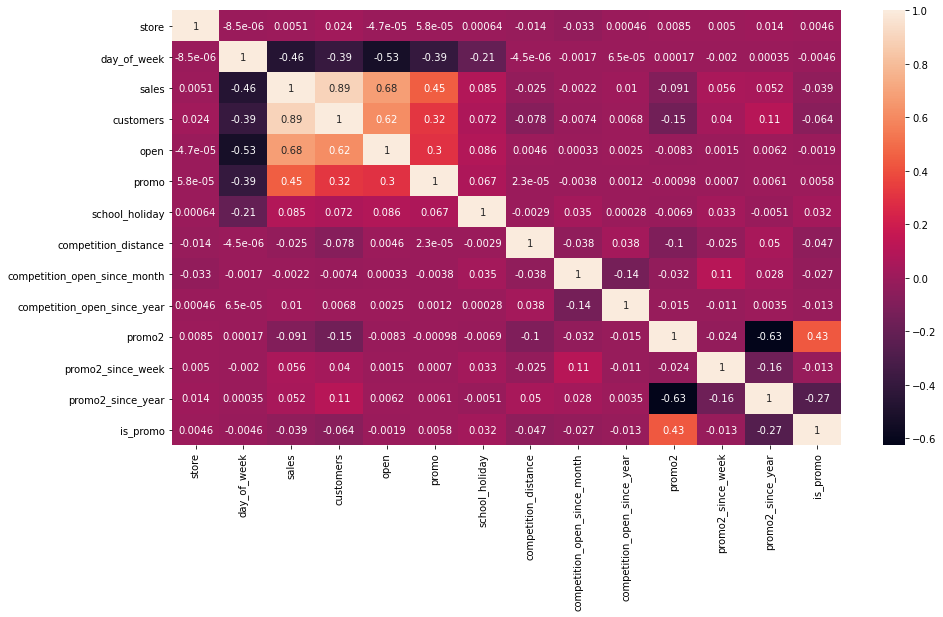

In [42]:
correlacao= num_attirbutes.corr(method='pearson')

fig=plt.figure(figsize=(15,8))
sns.heatmap(correlacao, annot=True)

### 4.3.1 Categorical Attibutes

In [43]:
#Only categorical data
a = df4.select_dtypes(include='object')

In [44]:
#Calculate cramer
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d= pd.DataFrame({'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]})
d= d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000003,0.071065,0.067546
store_type,0.071065,1.000003,0.538458
assortment,0.067546,0.538458,1.000003


<AxesSubplot:>

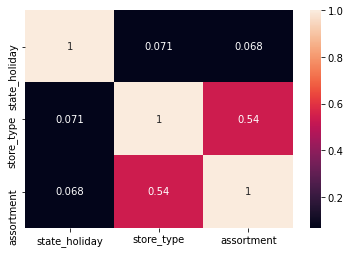

In [45]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [63]:
df5 = df4.copy()

## 5.1. Normalization

Não há variáveis com distrubuição normal

## 5.2 Rescaling

In [64]:
a = df5.select_dtypes(include = ['int64', 'float64'])

C:\Users\Daniela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Daniela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Daniela\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

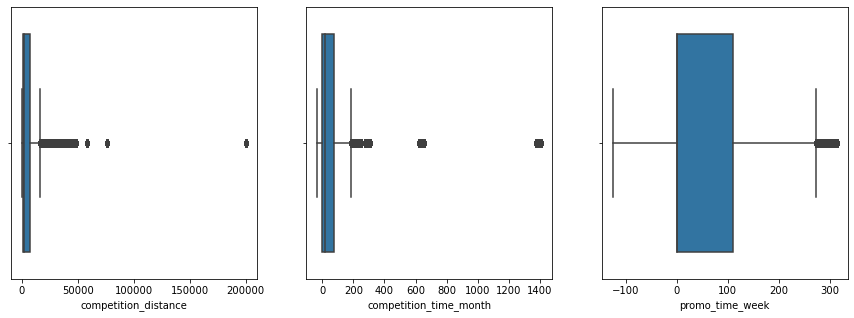

In [65]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(df5['competition_distance'])

plt.subplot(1,3,2)
sns.boxplot(df5['competition_time_month'])

plt.subplot(1,3,3)
sns.boxplot(df5['promo_time_week'])

In [66]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance']= rs.fit_transform(df5[['competition_distance']].values)

#competition_time_month
df5['competition_time_month']= rs.fit_transform(df5[['competition_time_month']].values)

#promo_time_week
df5['prmo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year']= mms.fit_transform(df5[['year']].values)

## 5.3 Transformation

In [62]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'prmo_time_week', 'state_holiday_christmas',
       'state_holiday_easter holiday', 'state_holiday_public holiday',
       'state_holiday_regular day'],
      dtype='object')

In [67]:
# state_holiday
df5 = pd.get_dummies(df5, prefix = 'state_holiday', columns = ['state_holiday'])

# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment
assortment_dict = {'basic': 1,
                  'extra': 2,
                  'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [71]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prmo_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,2015-30,2008-09-01,0.918919,2015-07-27,0,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,2015-30,2007-11-01,1.054054,2010-03-22,279,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,2015-30,2006-12-01,1.202703,2011-03-28,226,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,2015-30,2009-09-01,0.743243,2015-07-27,0,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,2015-30,2015-04-01,-0.162162,2015-07-27,0,0.287016,0,0,0,1


## 5.3.3 Transformação de natureza cíclica

In [74]:
# day_of week
df5['day_of_week_sin'] =  df5['day_of_week'].apply(lambda x: np.sin(x* (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2. * np.pi/7)))

# month
df5['month_sin'] =  df5['month'].apply(lambda x: np.sin(x* (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2. * np.pi/12)))

# day
df5['day_sin'] =  df5['day'].apply(lambda x: np.sin(x* (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x* (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] =  df5['week_of_year'].apply(lambda x: np.sin(x* (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2. * np.pi/52)))
